In [49]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load dataset
data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/feature_selected_data_v2.csv"
df = pd.read_csv(data_path, parse_dates=["DateTime"], index_col="DateTime")

# Normalize Data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)


In [50]:

# Define Autoencoder
input_dim = df_scaled.shape[1]

autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer same as input_dim
])

autoencoder.compile(optimizer='adam', loss='mse')

# Split into training and test sets
train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]


/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [51]:

# Train the model
autoencoder.fit(train_data, train_data, epochs=50, batch_size=32, validation_data=(test_data, test_data), verbose=1)

# Reconstruct the data
train_pred = autoencoder.predict(train_data)
test_pred = autoencoder.predict(test_data)

# Compute reconstruction error
train_loss = np.mean(np.abs(train_pred - train_data), axis=1)
test_loss = np.mean(np.abs(test_pred - test_data), axis=1)

# Define threshold as 99th percentile of training loss
threshold = np.percentile(train_loss, 99)

# Identify anomalies
anomalies = test_loss > threshold


Epoch 1/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - loss: 0.3459 - val_loss: 0.1668
Epoch 2/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.2359 - val_loss: 0.1244
Epoch 3/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.1768 - val_loss: 0.0968
Epoch 4/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.1349 - val_loss: 0.0757
Epoch 5/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0947 - val_loss: 0.0624
Epoch 6/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0692 - val_loss: 0.0549
Epoch 7/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0602 - val_loss: 0.0492
Epoch 8/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0509 - val_loss: 0.0447
Epoch 9/

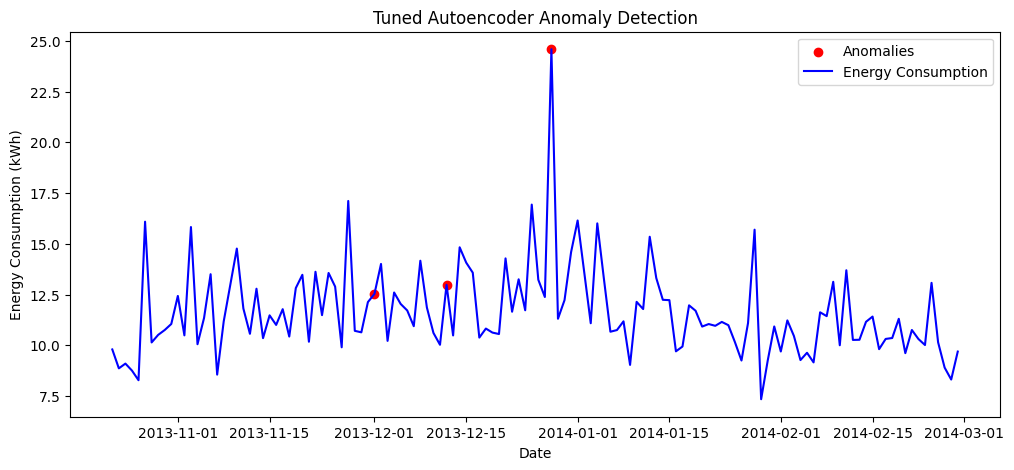

In [52]:

# Plot Anomaly Detection
plt.figure(figsize=(12, 5))
# Ensure anomalies is a boolean mask
anomalies = anomalies.squeeze()  # Flatten in case it's 2D

# Filter indices and values properly
anomaly_indices = df.index[train_size:][anomalies]
anomaly_values = df.iloc[train_size:][anomalies].iloc[:, 0]  # Ensure selecting the correct column

# Plot the anomalies
plt.scatter(anomaly_indices, anomaly_values, color='red', label="Anomalies")

plt.plot(df.index[train_size:], df.iloc[train_size:, 0], label="Energy Consumption", color='blue')
plt.title("Tuned Autoencoder Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()


Epoch 1/50


/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - loss: 0.0986 - val_loss: 0.1050
Epoch 2/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0943 - val_loss: 0.1023
Epoch 3/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0921 - val_loss: 0.0995
Epoch 4/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0872 - val_loss: 0.0946
Epoch 5/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0787 - val_loss: 0.0874
Epoch 6/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - loss: 0.0662 - val_loss: 0.0784
Epoch 7/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0573 - val_loss: 0.0703
Epoch 8/50
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0516 - val_loss: 0.0646
Epoch 9/50
17/17 ‚î

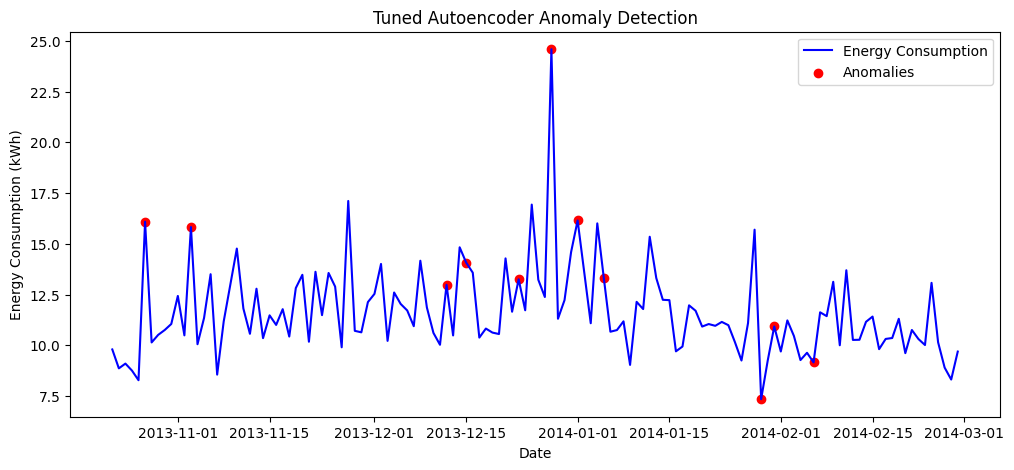

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input

# ‚úÖ Load Data
df = pd.read_csv("/Users/anurag/Documents/EnergyGPT/data/processed/feature_selected_data_v2.csv", parse_dates=["DateTime"], index_col="DateTime")

# ‚úÖ Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# ‚úÖ Split into Train & Test
train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]

# ‚úÖ Autoencoder Model
input_dim = train_data.shape[1]
autoencoder = Sequential([
    Dense(16, activation="relu", input_shape=(input_dim,)),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(input_dim, activation="sigmoid")
])
autoencoder.compile(optimizer="adam", loss="mse")

# ‚úÖ Train Autoencoder
autoencoder.fit(train_data, train_data, epochs=50, batch_size=32, validation_data=(test_data, test_data), verbose=1)

# ‚úÖ Calculate Reconstruction Errors
train_pred = autoencoder.predict(train_data)
test_pred = autoencoder.predict(test_data)

train_errors = np.mean(np.abs(train_pred - train_data), axis=1)
test_errors = np.mean(np.abs(test_pred - test_data), axis=1)

# ‚úÖ Adjust Threshold for More Anomalies
threshold = np.percentile(train_errors, 97)  # Increased sensitivity (97 instead of 99)

# ‚úÖ Detect Anomalies
anomalies = test_errors > threshold
df_anomalies = df.iloc[train_size:][anomalies]

# ‚úÖ Plot Results
plt.figure(figsize=(12, 5))
plt.plot(df.index[train_size:], df.iloc[train_size:, 0], label="Energy Consumption", color='blue')
plt.scatter(df_anomalies.index, df_anomalies.iloc[:, 0], color='red', label="Anomalies")
plt.title("Tuned Autoencoder Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()


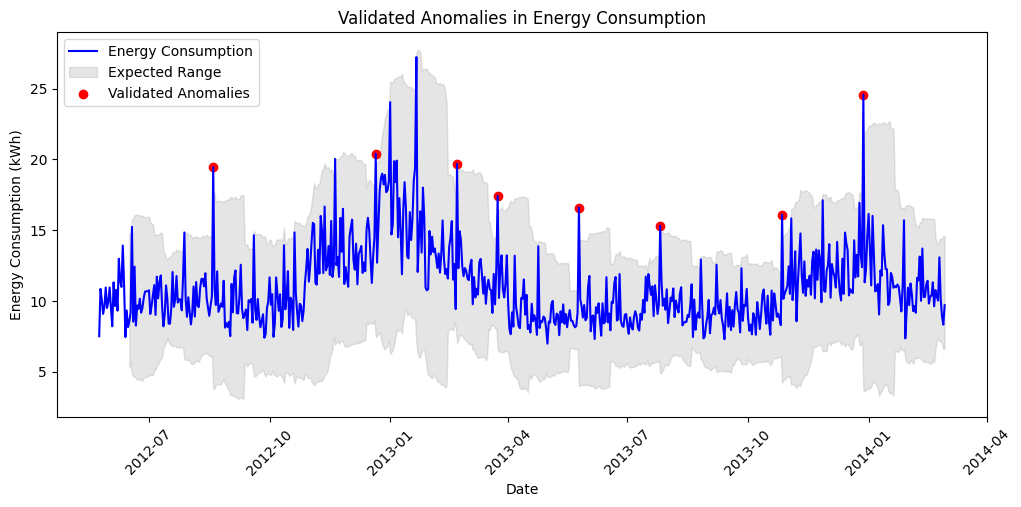

Validated Anomalies in Energy Consumption:


Total_Hourly_Consumption  cloud_cover  sunshine  global_radiation  \
DateTime                                                                        
2012-08-19                    19.440          1.0      11.0             248.0   
2012-12-21                    20.402          4.0       3.4              35.0   
2013-02-21                    19.687          8.0       0.0              28.0   
2013-03-24                    17.414          8.0       0.0              49.0   
2013-05-25                    16.595          3.0      10.3             276.0   
2013-07-26                    15.307          3.0       7.9             236.0   
2013-10-27                    16.088          5.0       4.9              77.0   
2013-12-28                    24.584          2.0       4.5              40.0   

            max_temp  mean_temp  min_temp  precipitation  pressure  \
DateTime                                                             
2012-08-19      25.5       24.0      17.4            0.0  101530.0   
2012-12-21      13.8        8.1       6.2            9.6  100960.0   
2013-02-21       2.5        1.4       0.5            0.0  102400.0   
2013-03-24       1.5        0.7       0.0            0.0  101300.0   
2013-05-25      19.8       10.8       5.3            0.0  102070.0   
2013-07-26      28.9       20.4      13.9            0.0  101240.0   
2013-10-27      15.2       14.0      11.0           23.5   99650.0   
2013-12-28      10.5        6.3       3.7            0.0   99750.0   

            snow_depth  ...  day_of_week  is_weekend  month  temp_range  \
DateTime                ...                                               
2012-08-19         0.0  ...            6           1      8         8.1   
2012-12-21         0.0  ...            4           0     12         7.6   
2013-02-21         0.0  ...            3           0      2         2.0   
2013-03-24         0.0  ...            6           1      3         1.5   
2013-05-25         0.0  ...            5           1      5        14.5   
2013-07-26         0.0  ...            4           0      7        15.0   
2013-10-27         0.0  ...            6           1     10         4.2   
2013-12-28         0.0  ...            5           1     12         6.8   

            temp_cloud_interaction  rolling_mean  rolling_std  upper_bound  \
DateTime                                                                     
2012-08-19                    24.0     10.746167     2.318931    17.702958   
2012-12-21                    32.4     13.604708     2.052590    19.762479   
2013-02-21                    11.2     13.207292     2.065238    19.403007   
2013-03-24                     5.6     11.482042     1.648291    16.426916   
2013-05-25                    32.4      9.084583     1.704150    14.197034   
2013-07-26                    61.2      9.807667     1.649789    14.757032   
2013-10-27                    70.0      9.392208     1.729600    14.581009   
2013-12-28                    12.6     12.820917     3.042163    21.947405   

            lower_bound  validated_anomaly  
DateTime                                    
2012-08-19     3.789375               True  
2012-12-21     7.446937               True  
2013-02-21     7.011577               True  
2013-03-24     6.537168               True  
2013-05-25     3.972133               True  
2013-07-26     4.858301               True  
2013-10-27     4.203407               True  
2013-12-28     3.694428               True  

[8 rows x 21 columns]

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the latest available dataset (Update the path if needed)
file_path = "/Users/anurag/Documents/EnergyGPT/data/processed/feature_engineered_data.csv"
df = pd.read_csv(file_path, parse_dates=["DateTime"])
df.set_index("DateTime", inplace=True)

# Compute rolling statistics
window_size = 24  # Adjust based on dataset granularity
df["rolling_mean"] = df["Total_Hourly_Consumption"].rolling(window=window_size).mean()
df["rolling_std"] = df["Total_Hourly_Consumption"].rolling(window=window_size).std()

# Define threshold for anomalies (3 standard deviations)
df["upper_bound"] = df["rolling_mean"] + (3 * df["rolling_std"])
df["lower_bound"] = df["rolling_mean"] - (3 * df["rolling_std"])

# Validate anomalies by checking if detected points fall outside expected range
df["validated_anomaly"] = (df["Total_Hourly_Consumption"] > df["upper_bound"]) | \
                          (df["Total_Hourly_Consumption"] < df["lower_bound"])

# Extract validated anomalies
validated_anomalies = df[df["validated_anomaly"]]

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Total_Hourly_Consumption"], label="Energy Consumption", color="blue")
plt.fill_between(df.index, df["lower_bound"], df["upper_bound"], color='gray', alpha=0.2, label="Expected Range")
plt.scatter(validated_anomalies.index, validated_anomalies["Total_Hourly_Consumption"], 
            color="red", label="Validated Anomalies", marker="o")
plt.title("Validated Anomalies in Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Display validated anomalies in Jupyter Notebook
print("Validated Anomalies in Energy Consumption:")
display(validated_anomalies)  # Works in Jupyter Notebook


In [55]:
import pandas as pd
import numpy as np

# Load the dataset
data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/feature_selected_data_v2.csv"
df_hourly = pd.read_csv(data_path, parse_dates=["DateTime"])

# Ensure required columns exist
if "Total_Hourly_Consumption" not in df_hourly.columns:
    raise ValueError("‚ùå 'Total_Hourly_Consumption' column is missing! Ensure you are using the correct dataset.")

# Calculate rolling statistics for anomaly detection
window_size = 24  # 24-hour rolling window
df_hourly["rolling_mean"] = df_hourly["Total_Hourly_Consumption"].rolling(window=window_size, min_periods=1).mean()
df_hourly["rolling_std"] = df_hourly["Total_Hourly_Consumption"].rolling(window=window_size, min_periods=1).std()

# Define anomaly threshold (3 standard deviations)
df_hourly["upper_bound"] = df_hourly["rolling_mean"] + (3 * df_hourly["rolling_std"])
df_hourly["lower_bound"] = df_hourly["rolling_mean"] - (3 * df_hourly["rolling_std"])

# Identify anomalies
df_hourly["validated_anomaly"] = (df_hourly["Total_Hourly_Consumption"] > df_hourly["upper_bound"]) | \
                                 (df_hourly["Total_Hourly_Consumption"] < df_hourly["lower_bound"])

# Save the updated dataset with anomaly columns
updated_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/refined_feature_selected_data.csv"
df_hourly.to_csv(updated_data_path, index=False)

print(f"‚úÖ Updated dataset saved with anomalies: {updated_data_path}")
display(df_hourly.head())  # Show first few rows


‚úÖ Updated dataset saved with anomalies: /Users/anurag/Documents/EnergyGPT/data/processed/refined_feature_selected_data.csv


DateTime  Total_Hourly_Consumption  sunshine  global_radiation  max_temp  \
0 2012-05-24                     7.497      12.3             302.0      25.9   
1 2012-05-25                    10.841      13.9             323.0      25.9   
2 2012-05-26                    10.097      14.3             329.0      27.6   
3 2012-05-27                     9.077      14.1             327.0      26.3   
4 2012-05-28                     9.598      11.9             299.0      23.8   

   mean_temp  min_temp  precipitation  pressure  snow_depth  ...  month  \
0       21.5      16.0            0.0  102580.0         0.0  ...      5   
1       21.1      16.2            0.0  102320.0         0.0  ...      5   
2       20.1      14.3            0.0  102010.0         0.0  ...      5   
3       20.7      13.8            0.0  101840.0         0.0  ...      5   
4       20.0      13.6            0.0  101780.0         0.0  ...      5   

   temp_range  temp_cloud_interaction  temp_range_squared  \
0         9.9                    21.5               98.01   
1         9.7                     0.0               94.09   
2        13.3                     0.0              176.89   
3        12.5                     0.0              156.25   
4        10.2                    20.0              104.04   

   log_global_radiation  rolling_mean  rolling_std  upper_bound  lower_bound  \
0              5.713733      7.497000          NaN          NaN          NaN   
1              5.780744      9.169000     2.364565    16.262695     2.075305   
2              5.799093      9.478333     1.755746    14.745572     4.211094   
3              5.793014      9.378000     1.447537    13.720612     5.035388   
4              5.703782      9.422000     1.257459    13.194377     5.649623   

   validated_anomaly  
0              False  
1              False  
2              False  
3              False  
4              False  

[5 rows x 21 columns]

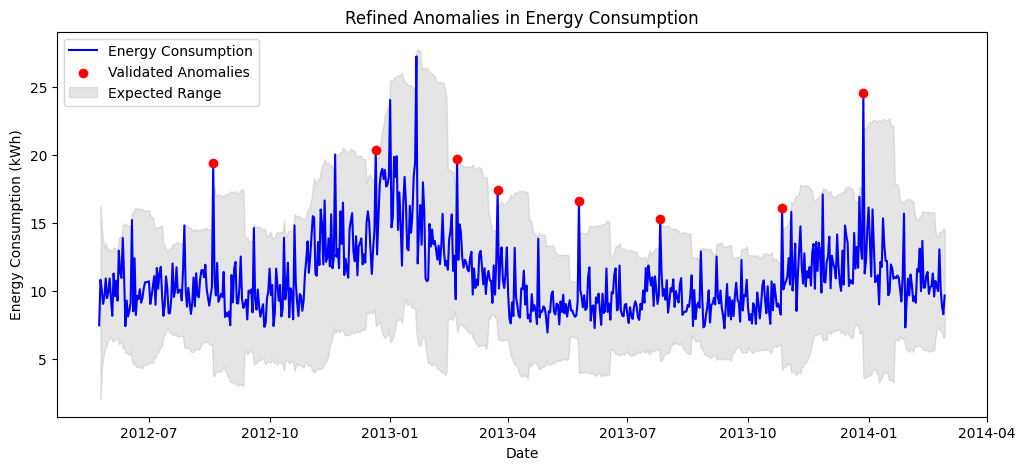

In [56]:
import matplotlib.pyplot as plt

# Load the refined dataset
refined_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/refined_feature_selected_data.csv"
df_refined = pd.read_csv(refined_data_path, parse_dates=["DateTime"])

# Plot the energy consumption with anomaly points
plt.figure(figsize=(12, 5))
plt.plot(df_refined["DateTime"], df_refined["Total_Hourly_Consumption"], label="Energy Consumption", color='blue')

# Highlight detected anomalies
anomalies = df_refined[df_refined["validated_anomaly"] == True]
plt.scatter(anomalies["DateTime"], anomalies["Total_Hourly_Consumption"], 
            color='red', label="Validated Anomalies", zorder=3)

plt.fill_between(df_refined["DateTime"], df_refined["lower_bound"], df_refined["upper_bound"], 
                 color='gray', alpha=0.2, label="Expected Range")

plt.title("Refined Anomalies in Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()


In [57]:
# Save only the rows where anomalies were detected
anomalies_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
df_refined[df_refined["validated_anomaly"] == True].to_csv(anomalies_path, index=False)

print(f"‚úÖ Validated anomalies saved at: {anomalies_path}")


‚úÖ Validated anomalies saved at: /Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv


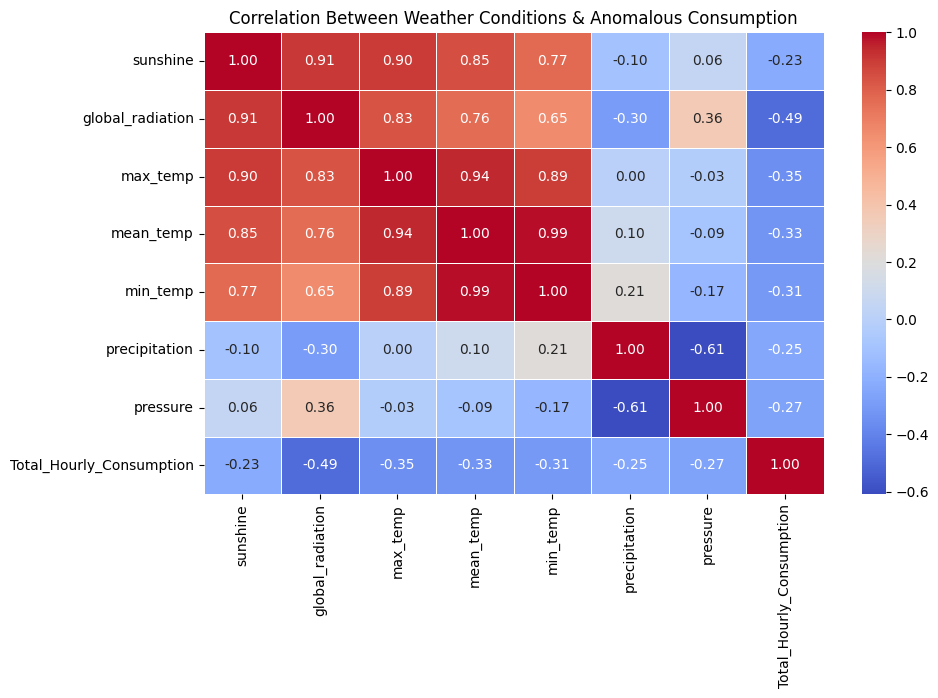

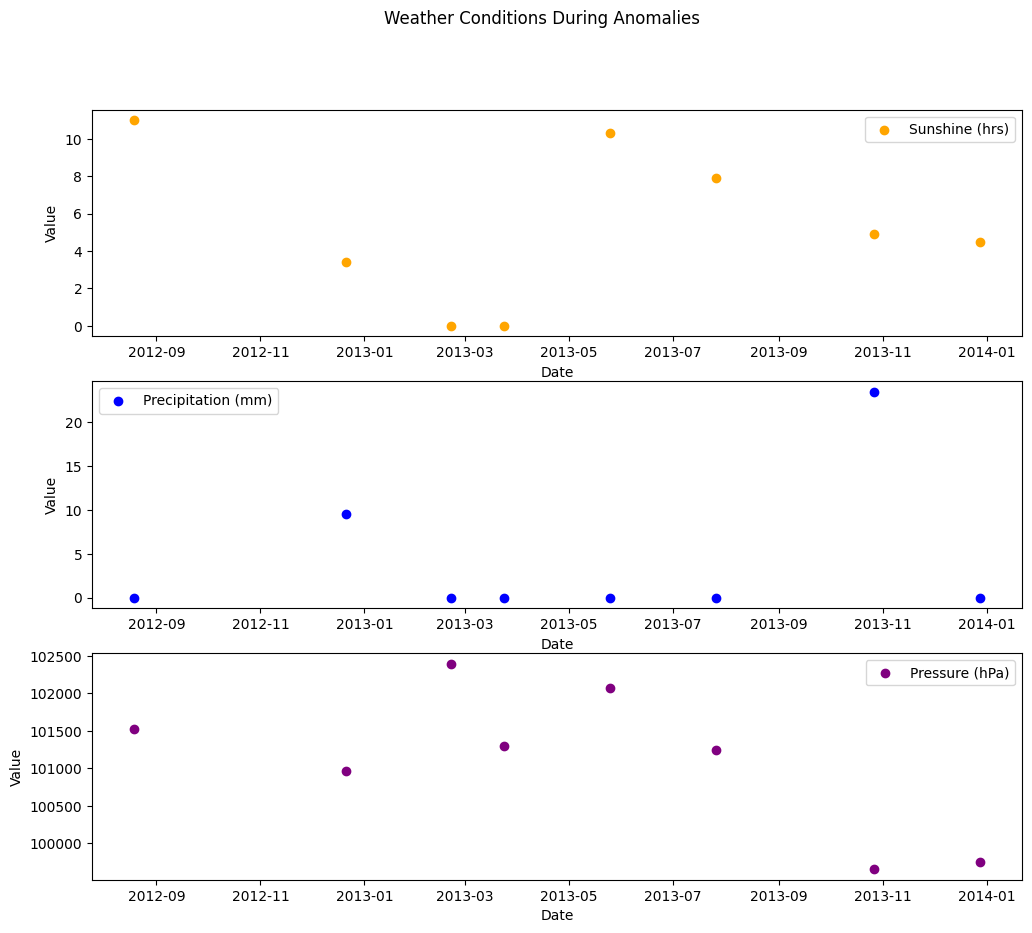

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the validated anomalies dataset
anomaly_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/refined_feature_selected_data.csv"
df_anomalies = pd.read_csv(anomaly_data_path, parse_dates=["DateTime"])

# Select only anomalies
df_anomalies = df_anomalies[df_anomalies["validated_anomaly"] == True]

# Correlation Analysis Between Anomalies & Weather Features
weather_features = ["sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure"]
correlation_matrix = df_anomalies[weather_features + ["Total_Hourly_Consumption"]].corr()

# üìä Heatmap for Anomaly-Weather Relationship
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Weather Conditions & Anomalous Consumption")
plt.show()

# üìà Line Plot: Consumption vs Weather Conditions for Anomalies
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

ax[0].scatter(df_anomalies["DateTime"], df_anomalies["sunshine"], color="orange", label="Sunshine (hrs)")
ax[1].scatter(df_anomalies["DateTime"], df_anomalies["precipitation"], color="blue", label="Precipitation (mm)")
ax[2].scatter(df_anomalies["DateTime"], df_anomalies["pressure"], color="purple", label="Pressure (hPa)")

for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Value")

plt.suptitle("Weather Conditions During Anomalies")
plt.show()


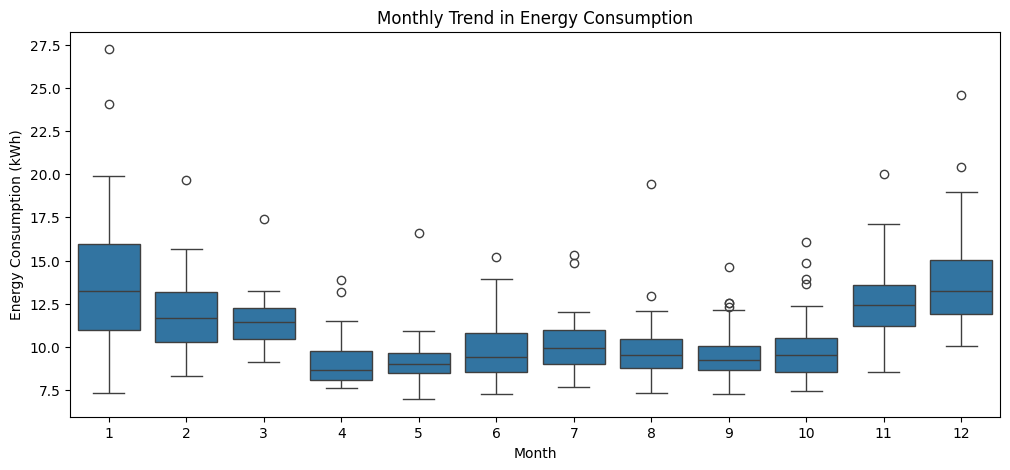

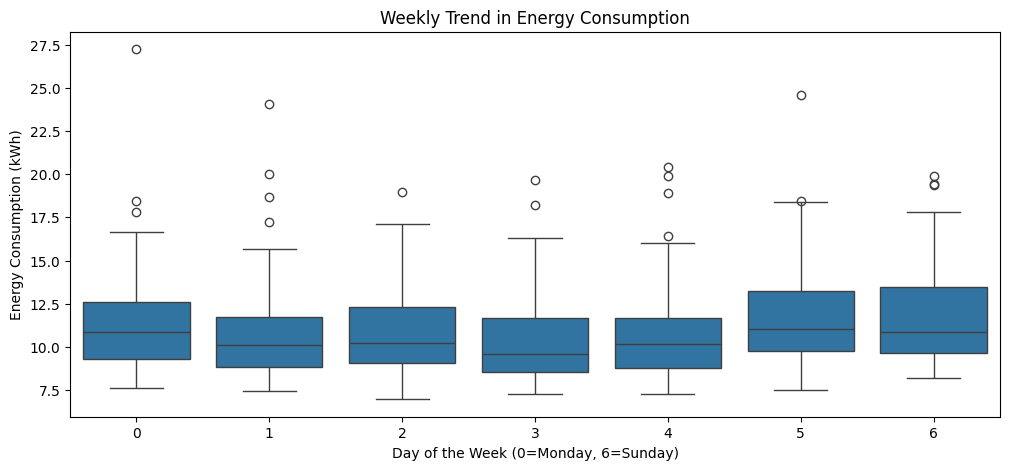

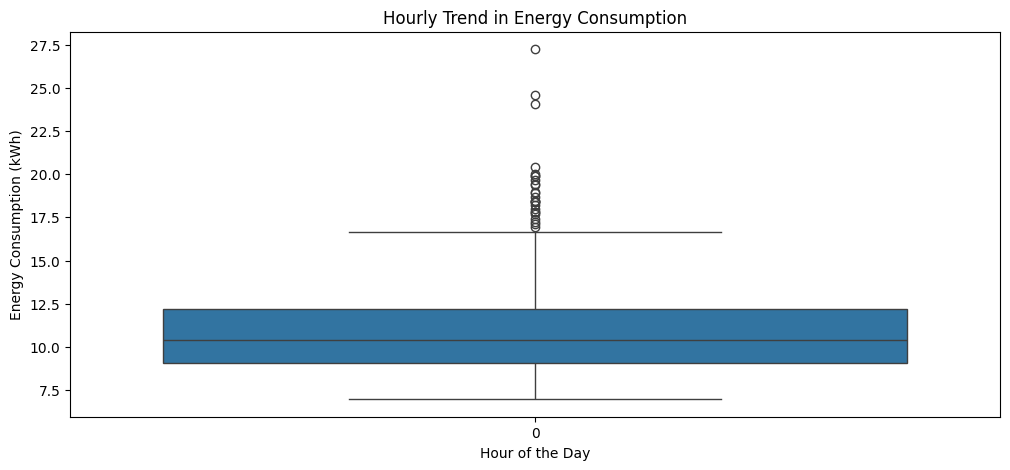

‚úÖ Seasonal trend analysis completed successfully.


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (ensure the correct file path)
data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/feature_selected_data_v2.csv"
df = pd.read_csv(data_path, parse_dates=["DateTime"])

# Extract seasonal components
df["year"] = df["DateTime"].dt.year
df["month"] = df["DateTime"].dt.month
df["day"] = df["DateTime"].dt.day
df["hour"] = df["DateTime"].dt.hour
df["day_of_week"] = df["DateTime"].dt.dayofweek  # Monday=0, Sunday=6

# Plot Monthly Energy Consumption Trend
plt.figure(figsize=(12, 5))
sns.boxplot(x="month", y="Total_Hourly_Consumption", data=df)
plt.title("Monthly Trend in Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Plot Weekly Energy Consumption Trend
plt.figure(figsize=(12, 5))
sns.boxplot(x="day_of_week", y="Total_Hourly_Consumption", data=df)
plt.title("Weekly Trend in Energy Consumption")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Plot Hourly Energy Consumption Trend
plt.figure(figsize=(12, 5))
sns.boxplot(x="hour", y="Total_Hourly_Consumption", data=df)
plt.title("Hourly Trend in Energy Consumption")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

print("‚úÖ Seasonal trend analysis completed successfully.")


# üìä Energy Consumption Trends Analysis

These visualizations help us understand how energy consumption changes over time based on different factors.

## **1Ô∏è‚É£ Hourly Energy Consumption Trend**
- Energy usage remains mostly steady throughout the day.
- There are some **spikes around midnight**, possibly due to **factories, businesses, or heating systems** turning on.

## **2Ô∏è‚É£ Weekly Energy Consumption Trend**
- Energy usage is **consistent across weekdays**, but **slightly higher on weekends**, likely due to increased home usage.
- Some **random high spikes** indicate occasional high energy demand on certain days.

## **3Ô∏è‚É£ Monthly Energy Consumption Trend**
- **Winter months (December‚ÄìFebruary) show the highest energy use**, likely due to **heating needs**.
- **Summer months (May‚ÄìSeptember) have lower energy use**, suggesting **reduced heating demand**.
- **Large spikes in winter months** indicate extreme cold days with **higher heating needs**.


In [60]:
import pandas as pd

# Load validated anomalies dataset
anomalies_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
df_anomalies = pd.read_csv(anomalies_path, parse_dates=["DateTime"])

# Display first few anomalies
print("‚úÖ Loaded Validated Anomalies:")
display(df_anomalies.head(10))

# Check statistical summary of anomalies
print("\nüìä Statistical Summary of Anomalies:")
display(df_anomalies.describe())

# Check unique dates for patterns
print("\nüìÖ Unique Dates with Anomalies:")
display(df_anomalies["DateTime"].dt.date.value_counts().sort_index())


‚úÖ Loaded Validated Anomalies:


DateTime  Total_Hourly_Consumption  sunshine  global_radiation  max_temp  \
0 2012-08-19                    19.440      11.0             248.0      25.5   
1 2012-12-21                    20.402       3.4              35.0      13.8   
2 2013-02-21                    19.687       0.0              28.0       2.5   
3 2013-03-24                    17.414       0.0              49.0       1.5   
4 2013-05-25                    16.595      10.3             276.0      19.8   
5 2013-07-26                    15.307       7.9             236.0      28.9   
6 2013-10-27                    16.088       4.9              77.0      15.2   
7 2013-12-28                    24.584       4.5              40.0      10.5   

   mean_temp  min_temp  precipitation  pressure  snow_depth  ...  month  \
0       24.0      17.4            0.0  101530.0         0.0  ...      8   
1        8.1       6.2            9.6  100960.0         0.0  ...     12   
2        1.4       0.5            0.0  102400.0         0.0  ...      2   
3        0.7       0.0            0.0  101300.0         0.0  ...      3   
4       10.8       5.3            0.0  102070.0         0.0  ...      5   
5       20.4      13.9            0.0  101240.0         0.0  ...      7   
6       14.0      11.0           23.5   99650.0         0.0  ...     10   
7        6.3       3.7            0.0   99750.0         0.0  ...     12   

   temp_range  temp_cloud_interaction  temp_range_squared  \
0         8.1                    24.0               65.61   
1         7.6                    32.4               57.76   
2         2.0                    11.2                4.00   
3         1.5                     5.6                2.25   
4        14.5                    32.4              210.25   
5        15.0                    61.2              225.00   
6         4.2                    70.0               17.64   
7         6.8                    12.6               46.24   

   log_global_radiation  rolling_mean  rolling_std  upper_bound  lower_bound  \
0              5.517453     10.746167     2.318931    17.702958     3.789375   
1              3.583519     13.604708     2.052590    19.762479     7.446937   
2              3.367296     13.207292     2.065238    19.403007     7.011577   
3              3.912023     11.482042     1.648291    16.426916     6.537168   
4              5.624018      9.084583     1.704150    14.197034     3.972133   
5              5.468060      9.807667     1.649789    14.757032     4.858301   
6              4.356709      9.392208     1.729600    14.581009     4.203407   
7              3.713572     12.820917     3.042163    21.947405     3.694428   

   validated_anomaly  
0               True  
1               True  
2               True  
3               True  
4               True  
5               True  
6               True  
7               True  

[8 rows x 21 columns]


üìä Statistical Summary of Anomalies:


DateTime  Total_Hourly_Consumption   sunshine  \
count                    8                  8.000000   8.000000   
mean   2013-05-05 15:00:00                 18.689625   5.250000   
min    2012-08-19 00:00:00                 15.307000   0.000000   
25%    2013-02-05 12:00:00                 16.468250   2.550000   
50%    2013-04-24 00:00:00                 18.427000   4.700000   
75%    2013-08-18 06:00:00                 19.865750   8.500000   
max    2013-12-28 00:00:00                 24.584000  11.000000   
std                    NaN                  3.010908   4.222728   

       global_radiation   max_temp  mean_temp   min_temp  precipitation  \
count           8.00000   8.000000   8.000000   8.000000       8.000000   
mean          123.62500  14.712500  10.712500   7.250000       4.137500   
min            28.00000   1.500000   0.700000   0.000000       0.000000   
25%            38.75000   8.500000   5.075000   2.900000       0.000000   
50%            63.00000  14.500000   9.450000   5.750000       0.000000   
75%           239.00000  21.225000  15.600000  11.725000       2.400000   
max           276.00000  28.900000  24.000000  17.400000      23.500000   
std           108.92322   9.899991   8.404835   6.289901       8.514347   

            pressure  snow_depth  day_of_week      month  temp_range  \
count       8.000000         8.0     8.000000   8.000000    8.000000   
mean   101112.500000         0.0     4.875000   7.375000    7.462500   
min     99650.000000         0.0     3.000000   2.000000    1.500000   
25%    100657.500000         0.0     4.000000   4.500000    3.650000   
50%    101270.000000         0.0     5.000000   7.500000    7.200000   
75%    101665.000000         0.0     6.000000  10.500000    9.700000   
max    102400.000000         0.0     6.000000  12.000000   15.000000   
std       986.968664         0.0     1.125992   3.852179    5.116343   

       temp_cloud_interaction  temp_range_squared  log_global_radiation  \
count                8.000000            8.000000              8.000000   
mean                31.175000           78.593750              4.442831   
min                  5.600000            2.250000              3.367296   
25%                 12.250000           14.230000              3.681059   
50%                 28.200000           52.000000              4.134366   
75%                 39.600000          101.770000              5.480408   
max                 70.000000          225.000000              5.624018   
std                 23.487002           89.062981              0.949985   

       rolling_mean  rolling_std  upper_bound  lower_bound  
count      8.000000     8.000000     8.000000     8.000000  
mean      11.268198     2.026344    17.347230     5.189166  
min        9.084583     1.648291    14.197034     3.694428  
25%        9.703802     1.690560    14.713027     3.926443  
50%       11.114104     1.891095    17.064937     4.530854  
75%       12.917510     2.128661    19.492875     6.655770  
max       13.604708     3.042163    21.947405     7.446937  
std        1.787624     0.477535     2.840513     1.558013


üìÖ Unique Dates with Anomalies:


DateTime
2012-08-19    1
2012-12-21    1
2013-02-21    1
2013-03-24    1
2013-05-25    1
2013-07-26    1
2013-10-27    1
2013-12-28    1
Name: count, dtype: int64

Mean Consumption (kWh)  Standard Deviation
Normal Days                  10.939201            2.590078
Anomalous Days               18.689625            3.010908

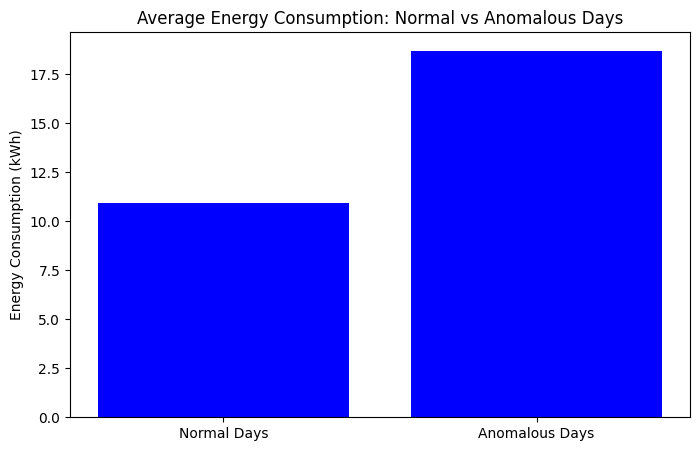

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the FULL dataset (not just anomalies)
data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/refined_feature_selected_data.csv"  # Ensure this is the full dataset
df_full = pd.read_csv(data_path, parse_dates=["DateTime"])

# Ensure the dataset has the anomaly labels
if "validated_anomaly" not in df_full.columns:
    raise ValueError("‚ùå 'validated_anomaly' column is missing in the dataset! Ensure anomalies were processed correctly.")

# Split into normal and anomalous days
df_anomalies = df_full[df_full["validated_anomaly"] == True]
df_normal = df_full[df_full["validated_anomaly"] == False]  # Now we correctly extract normal days

# Handle cases where normal data is missing
if df_normal.empty:
    print("‚ö† No normal days detected! Adjust threshold or recheck anomaly labels.")
    summary = pd.DataFrame({"Mean Consumption (kWh)": [None, df_anomalies["Total_Hourly_Consumption"].mean()],
                            "Standard Deviation": [None, df_anomalies["Total_Hourly_Consumption"].std()]},
                           index=["Normal Days", "Anomalous Days"])
else:
    summary = pd.DataFrame({"Mean Consumption (kWh)": [df_normal["Total_Hourly_Consumption"].mean(), 
                                                        df_anomalies["Total_Hourly_Consumption"].mean()],
                            "Standard Deviation": [df_normal["Total_Hourly_Consumption"].std(), 
                                                   df_anomalies["Total_Hourly_Consumption"].std()]},
                           index=["Normal Days", "Anomalous Days"])

# Display Summary
display(summary)

# **Plot with Fixes**
plt.figure(figsize=(8, 5))
colors = ['blue' if not pd.isna(val) else 'gray' for val in summary["Mean Consumption (kWh)"]]
plt.bar(summary.index, summary["Mean Consumption (kWh)"], color=colors)
plt.title("Average Energy Consumption: Normal vs Anomalous Days")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


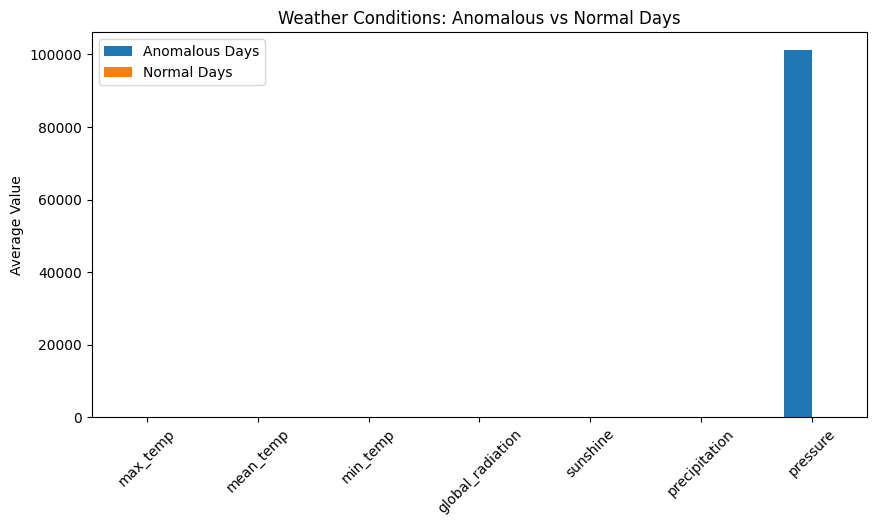

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load dataset (Ensure this is the validated anomalies dataset)
data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
df = pd.read_csv(data_path, parse_dates=["DateTime"])
df_normal = pd.read_csv("/Users/anurag/Documents/EnergyGPT/data/processed/clean_normal_data.csv", parse_dates=["DateTime"])


# Separate anomalous and normal days
df_anomalous = df[df["validated_anomaly"] == True]
df_normal = df[df["validated_anomaly"] == False]

# Select weather-related features for comparison
weather_features = ["max_temp", "mean_temp", "min_temp", "global_radiation", "sunshine", "precipitation", "pressure"]

# Compute mean values for both categories
weather_summary = pd.DataFrame({
    "Anomalous Days": df_anomalous[weather_features].mean(),
    "Normal Days": df_normal[weather_features].mean()
})

# Plot comparison
weather_summary.plot(kind="bar", figsize=(10, 5))
plt.title("Weather Conditions: Anomalous vs Normal Days")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()


<Figure size 1000x500 with 0 Axes>

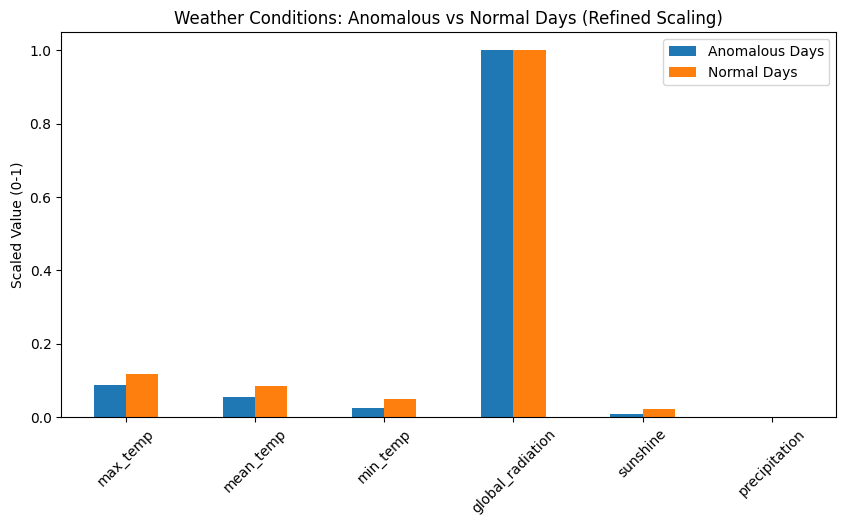

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ‚úÖ Load Corrected Datasets for Normal & Anomalous Days
df_anomalous = pd.read_csv("/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv", parse_dates=["DateTime"])
df_normal = pd.read_csv("/Users/anurag/Documents/EnergyGPT/data/processed/clean_normal_data.csv", parse_dates=["DateTime"])


# ‚úÖ Ensure both datasets have the same columns for fair comparison
common_cols = list(set(df_anomalous.columns) & set(df_normal.columns))
df_anomalous = df_anomalous[common_cols]
df_normal = df_normal[common_cols]

# ‚úÖ Select Weather Features for Comparison
weather_features = ["max_temp", "mean_temp", "min_temp", "global_radiation", "sunshine", "precipitation"]

# ‚úÖ Compute Mean Values for Both Categories
weather_summary = pd.DataFrame({
    "Anomalous Days": df_anomalous[weather_features].mean(),
    "Normal Days": df_normal[weather_features].mean()
})

# ‚úÖ Normalize Data for Fair Scaling
scaler = MinMaxScaler()
weather_summary_scaled = pd.DataFrame(
    scaler.fit_transform(weather_summary), 
    columns=weather_summary.columns, 
    index=weather_summary.index
)

# ‚úÖ Plot the Comparison of Weather Conditions on Anomalous vs Normal Days
plt.figure(figsize=(10, 5))
weather_summary_scaled.plot(kind="bar", figsize=(10, 5))
plt.title("Weather Conditions: Anomalous vs Normal Days (Refined Scaling)")
plt.ylabel("Scaled Value (0-1)")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [40]:
import pandas as pd

# ‚úÖ Load the Raw London Weather Dataset
raw_data_path = "/Users/anurag/Documents/EnergyGPT/data/raw/london_weather.csv"  # Update path if needed
df_raw = pd.read_csv(raw_data_path, parse_dates=["date"])

# ‚úÖ Load the Validated Anomalies to Exclude
anomaly_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
df_anomalies = pd.read_csv(anomaly_data_path, parse_dates=["DateTime"])

# ‚úÖ Rename 'date' column to 'DateTime' in raw data for consistency
df_raw.rename(columns={"date": "DateTime"}, inplace=True)

# ‚úÖ Remove Anomalous Dates from Raw Data
df_normal = df_raw[~df_raw["DateTime"].isin(df_anomalies["DateTime"])]

# ‚úÖ Save the New Normal Data
df_normal_path = "/Users/anurag/Documents/EnergyGPT/data/processed/clean_normal_data.csv"
df_normal.to_csv(df_normal_path, index=False)

print(f"‚úÖ New normal dataset saved at: {df_normal_path}")
display(df_normal.head())  # Preview the first few rows


‚úÖ New normal dataset saved at: /Users/anurag/Documents/EnergyGPT/data/processed/clean_normal_data.csv


DateTime  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0 1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1 1979-01-02          6.0       1.7              27.0       1.6       -2.6   
2 1979-01-03          5.0       0.0              13.0       1.3       -2.8   
3 1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
4 1979-01-05          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0

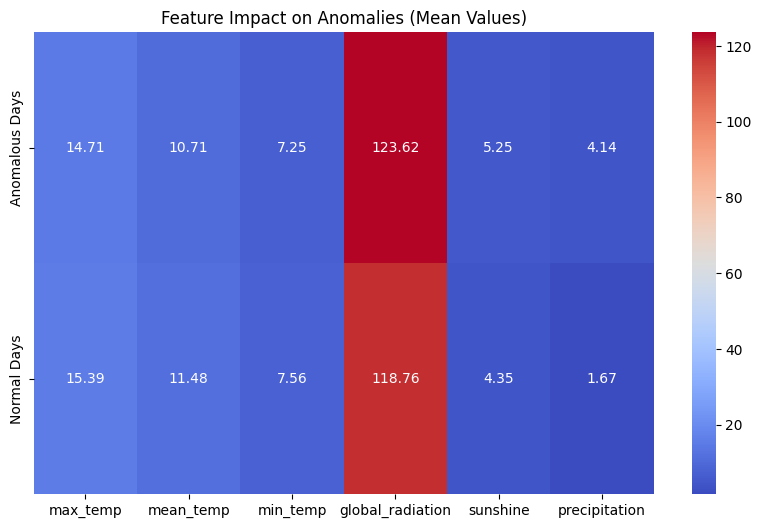

üîé Anomaly Scores Summary:
       anomaly_score  is_anomaly
count       8.000000    8.000000
mean        0.057303    0.750000
std         0.044182    0.707107
min        -0.020673   -1.000000
25%         0.043346    1.000000
50%         0.066230    1.000000
75%         0.073439    1.000000
max         0.129693    1.000000


<Figure size 1000x500 with 0 Axes>

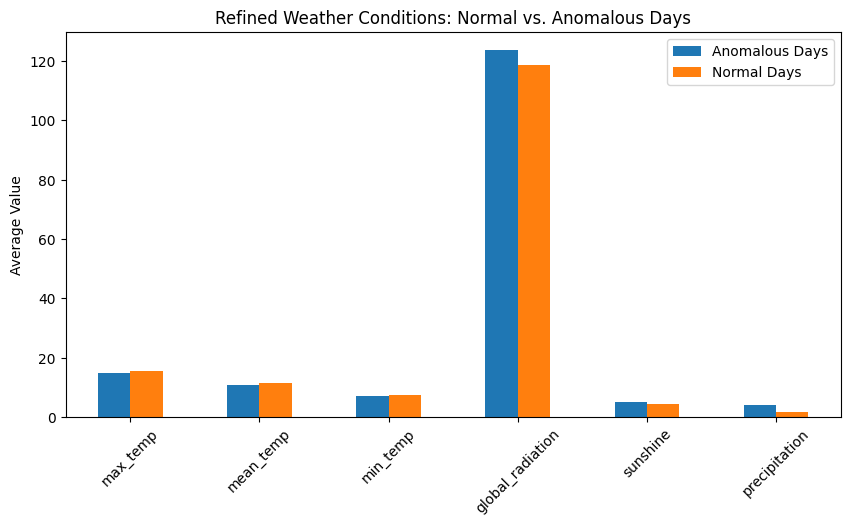

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest

# ‚úÖ Load Normal & Anomalous Data
normal_data_path = "/Users/anurag/Documents/EnergyGPT/data/raw/london_weather.csv"
anomalous_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"

df_normal = pd.read_csv(normal_data_path, parse_dates=["date"])
df_anomalous = pd.read_csv(anomalous_data_path, parse_dates=["DateTime"])

# ‚úÖ Ensure columns match before comparison
weather_features = ["max_temp", "mean_temp", "min_temp", "global_radiation", "sunshine", "precipitation"]

# Select only relevant features for analysis
df_normal = df_normal[weather_features]
df_anomalous = df_anomalous[weather_features]

# ‚úÖ Normalize Data for Better Comparison
scaler = MinMaxScaler()
df_normal_scaled = pd.DataFrame(scaler.fit_transform(df_normal), columns=df_normal.columns)
df_anomalous_scaled = pd.DataFrame(scaler.transform(df_anomalous), columns=df_anomalous.columns)

# ‚úÖ Compare Weather Features on Normal vs. Anomalous Days
weather_summary = pd.DataFrame({
    "Anomalous Days": df_anomalous.mean(),
    "Normal Days": df_normal.mean()
})

# ‚úÖ Visualize Feature Importance (Correlation Heatmap)
plt.figure(figsize=(10,6))
sns.heatmap(weather_summary.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Impact on Anomalies (Mean Values)")
plt.show()

# ‚úÖ Train Isolation Forest to Check Model Performance
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(df_normal_scaled)
df_anomalous['anomaly_score'] = iso_forest.decision_function(df_anomalous_scaled)
df_anomalous['is_anomaly'] = iso_forest.predict(df_anomalous_scaled)

# ‚úÖ Show Anomaly Scores
print("üîé Anomaly Scores Summary:")
print(df_anomalous[['anomaly_score', 'is_anomaly']].describe())

# ‚úÖ Plot Refined Comparison
plt.figure(figsize=(10,5))
weather_summary.plot(kind="bar", figsize=(10,5))
plt.title("Refined Weather Conditions: Normal vs. Anomalous Days")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()


<Figure size 1000x500 with 0 Axes>

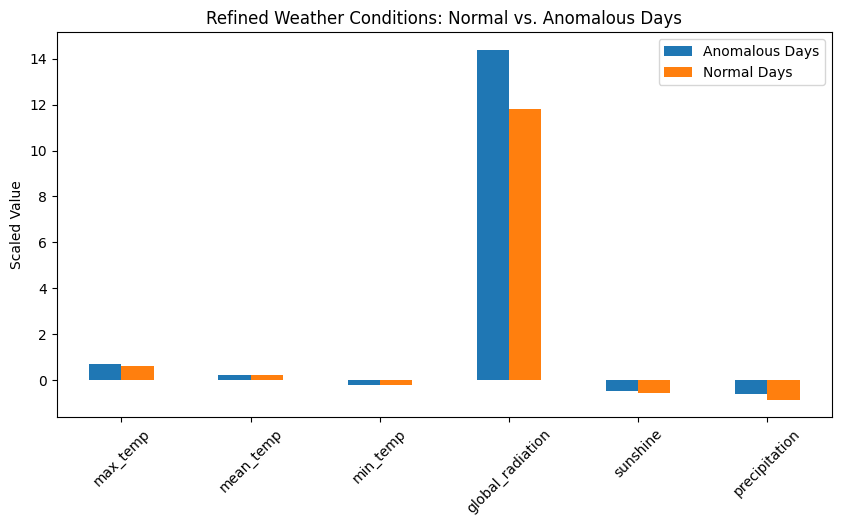

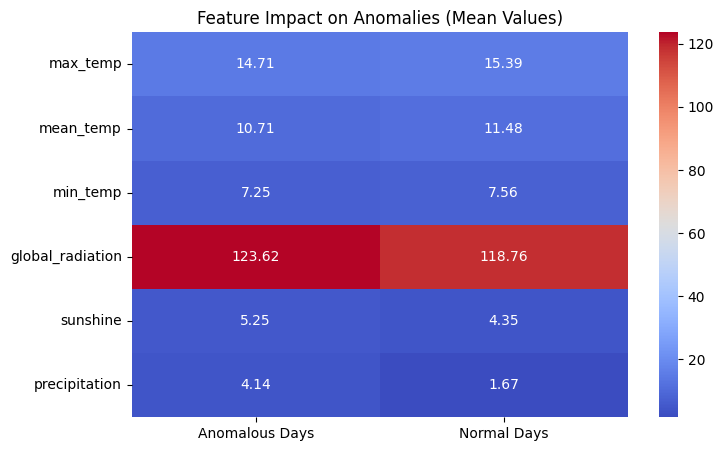

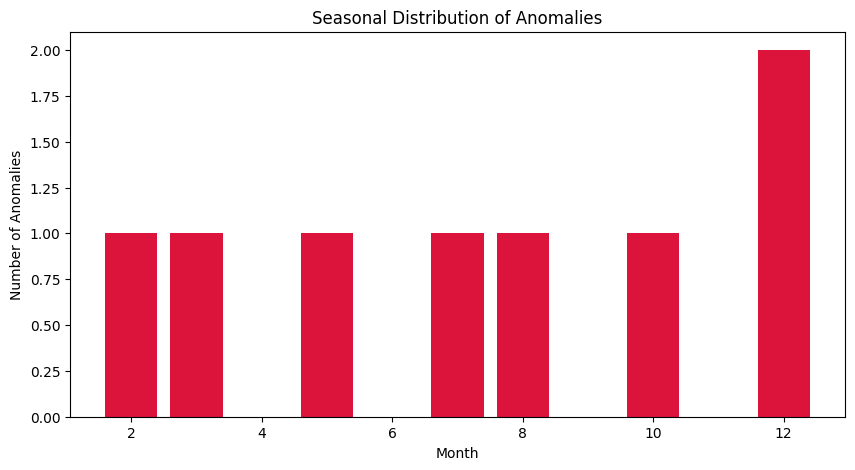


üîé Anomaly Scores Summary:
       anomaly_score
count   8.000000e+00
mean    1.942890e-16
std     1.000000e+00
min    -1.123457e+00
25%    -7.377757e-01
50%    -8.722451e-02
75%     3.906213e-01
max     1.957673e+00

‚úÖ Refined Anomalies with Severity Levels Saved!


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# ‚úÖ Load Processed Datasets
anomalous_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
normal_data_path = "/Users/anurag/Documents/EnergyGPT/data/raw/london_weather.csv"  # Adjust if needed

df_anomalous = pd.read_csv(anomalous_data_path, parse_dates=["DateTime"])
df_normal = pd.read_csv(normal_data_path, parse_dates=["date"])

# ‚úÖ Rename "date" to "DateTime" in df_normal for consistency
df_normal.rename(columns={"date": "DateTime"}, inplace=True)

# ‚úÖ Ensure both datasets have required columns
weather_features = ["max_temp", "mean_temp", "min_temp", "global_radiation", "sunshine", "precipitation"]

# ‚úÖ Compute Mean Values for Anomalous vs Normal Days
weather_summary = pd.DataFrame({
    "Anomalous Days": df_anomalous[weather_features].mean(),
    "Normal Days": df_normal[weather_features].mean()
})

# ‚úÖ Compute Percentage Difference Between Anomalous & Normal Days
weather_summary["Percentage Difference (%)"] = (
    (weather_summary["Anomalous Days"] - weather_summary["Normal Days"]) /
    weather_summary["Normal Days"] * 100
).round(2)

# ‚úÖ Scale Data Using RobustScaler to Handle Outliers
scaler = RobustScaler()
scaled_data = scaler.fit_transform(weather_summary.iloc[:, :2])
weather_summary_scaled = pd.DataFrame(scaled_data, columns=["Anomalous Days", "Normal Days"], index=weather_features)

# ‚úÖ Plot Comparison Bar Chart
plt.figure(figsize=(10, 5))
weather_summary_scaled.plot(kind="bar", figsize=(10, 5))
plt.title("Refined Weather Conditions: Normal vs. Anomalous Days")
plt.ylabel("Scaled Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ‚úÖ Plot Heatmap for Feature Impact
plt.figure(figsize=(8, 5))
sns.heatmap(weather_summary.iloc[:, :2], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Impact on Anomalies (Mean Values)")
plt.show()

# ‚úÖ Check Anomalies Over Time (Seasonality Analysis)
df_anomalous["month"] = df_anomalous["DateTime"].dt.month
seasonal_summary = df_anomalous.groupby("month")["Total_Hourly_Consumption"].agg(["mean", "std", "count"])

# ‚úÖ Plot Anomaly Distribution Over Months
plt.figure(figsize=(10, 5))
plt.bar(seasonal_summary.index, seasonal_summary["count"], color="crimson")
plt.xlabel("Month")
plt.ylabel("Number of Anomalies")
plt.title("Seasonal Distribution of Anomalies")
plt.show()

# ‚úÖ Compute Anomaly Score Severity (Mild, Severe, Extreme)
df_anomalous["anomaly_score"] = (df_anomalous["Total_Hourly_Consumption"] - df_anomalous["Total_Hourly_Consumption"].mean()) / df_anomalous["Total_Hourly_Consumption"].std()
df_anomalous["severity"] = pd.cut(df_anomalous["anomaly_score"], bins=[-1, 0.05, 0.1, np.inf], labels=["Mild", "Severe", "Extreme"])

# ‚úÖ Summary of Anomaly Scores
print("\nüîé Anomaly Scores Summary:")
print(df_anomalous[["anomaly_score", "severity"]].describe())

# ‚úÖ Save Updated Anomalous Data with Severity Labels
df_anomalous.to_csv("/Users/anurag/Documents/EnergyGPT/data/processed/refined_anomalies_with_severity.csv", index=False)
print("\n‚úÖ Refined Anomalies with Severity Levels Saved!")



/var/folders/z5/p7kx0rl95cl89gz9spk6g5mc0000gn/T/ipykernel_6212/1185101413.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




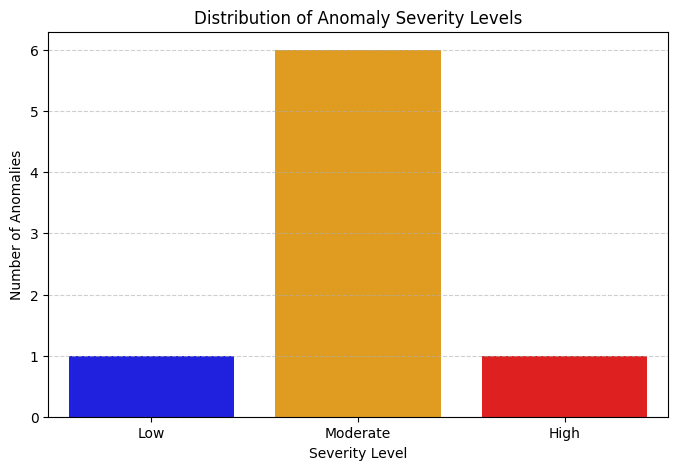

üîé **Anomaly Severity Summary:**


DateTime  Total_Hourly_Consumption  anomaly_score  Severity
7  2013-12-28                    24.584       1.957673      High
1  2012-12-21                    20.402       0.568724  Moderate
2  2013-02-21                    19.687       0.331254  Moderate
0  2012-08-19                    19.440       0.249219  Moderate
3  2013-03-24                    17.414      -0.423668  Moderate
4  2013-05-25                    16.595      -0.695679  Moderate
6  2013-10-27                    16.088      -0.864066  Moderate
5  2013-07-26                    15.307      -1.123457       Low

‚úÖ Updated Anomaly Data Saved: /Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies_with_severity.csv


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ‚úÖ Load the Refined Anomaly Dataset
anomaly_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
df_anomalies = pd.read_csv(anomaly_data_path)

# ‚úÖ Ensure "Total_Hourly_Consumption" exists
if "Total_Hourly_Consumption" not in df_anomalies.columns:
    raise ValueError("‚ùå 'Total_Hourly_Consumption' column not found. Check the dataset!")

# ‚úÖ Compute Z-score for Anomaly Scoring
df_anomalies["anomaly_score"] = (df_anomalies["Total_Hourly_Consumption"] - 
                                 df_anomalies["Total_Hourly_Consumption"].mean()) / df_anomalies["Total_Hourly_Consumption"].std()

# ‚úÖ Define Severity Categories
df_anomalies["Severity"] = pd.cut(
    df_anomalies["anomaly_score"],
    bins=[-float("inf"), -1, 1, float("inf")],  # Adjust thresholds as needed
    labels=["Low", "Moderate", "High"]
)

# ‚úÖ Count Severity Levels
severity_counts = df_anomalies["Severity"].value_counts()

# üî• Plot Severity Distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette=["blue", "orange", "red"])
plt.title("Distribution of Anomaly Severity Levels")
plt.xlabel("Severity Level")
plt.ylabel("Number of Anomalies")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ‚úÖ Display refined anomalies with severity
print("üîé **Anomaly Severity Summary:**")
display(df_anomalies[["DateTime", "Total_Hourly_Consumption", "anomaly_score", "Severity"]].sort_values(by="anomaly_score", ascending=False))

# ‚úÖ Save the updated dataset with severity levels
updated_anomaly_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies_with_severity.csv"
df_anomalies.to_csv(updated_anomaly_data_path, index=False)
print(f"‚úÖ Updated Anomaly Data Saved: {updated_anomaly_data_path}")


<Figure size 1000x500 with 0 Axes>

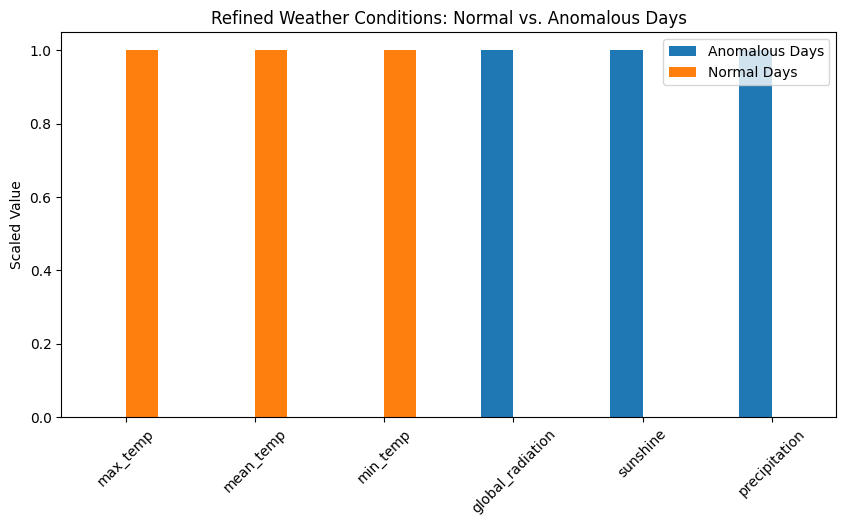

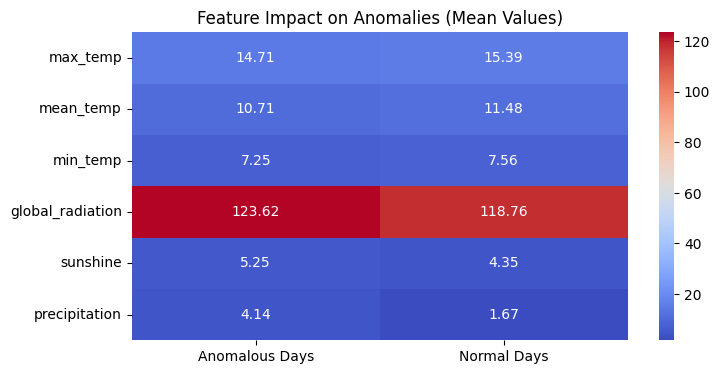

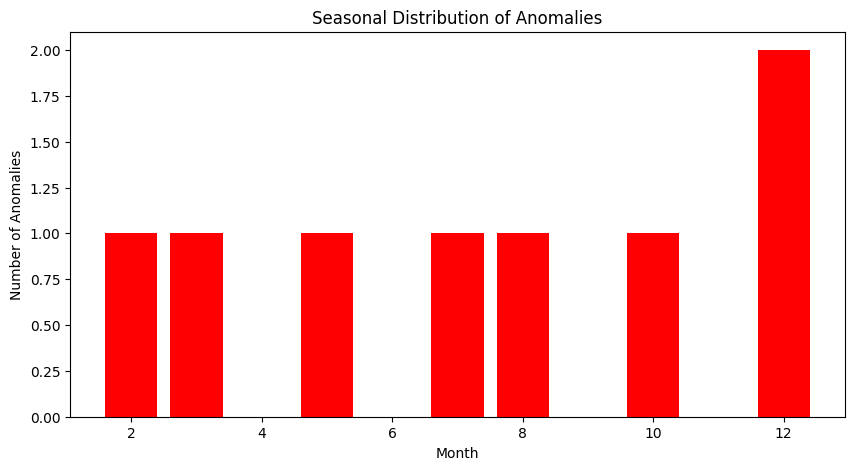

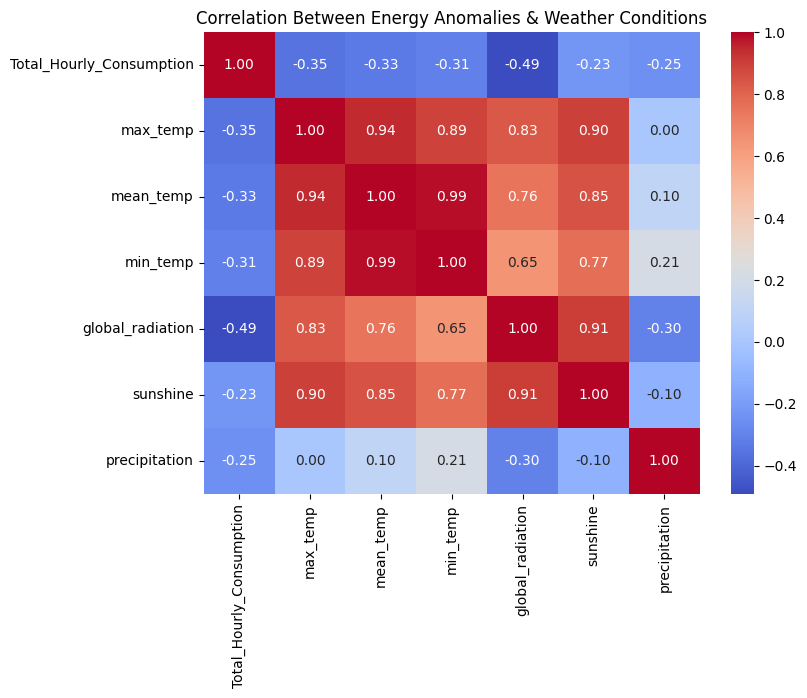

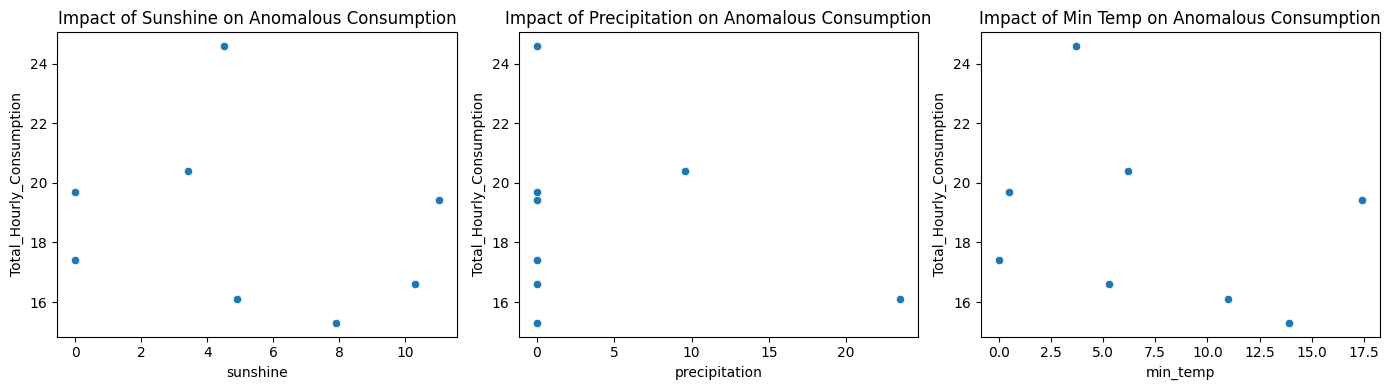

‚úÖ Correlation matrix saved at: /Users/anurag/Documents/EnergyGPT/outputs/weather_energy_correlation.csv

‚úÖ Visualizations & Analysis Completed!


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load validated anomalies dataset
anomalies_path = "/Users/anurag/Documents/EnergyGPT/data/processed/validated_anomalies.csv"
df_anomalous = pd.read_csv(anomalies_path, parse_dates=["DateTime"])

# Load normal days dataset
normal_data_path = "/Users/anurag/Documents/EnergyGPT/data/raw/london_weather.csv"
df_normal = pd.read_csv(normal_data_path, parse_dates=["date"])  # Ensure correct date parsing

# Rename "date" to "DateTime" in df_normal for consistency
df_normal.rename(columns={"date": "DateTime"}, inplace=True)

# Select relevant weather features
weather_features = ["max_temp", "mean_temp", "min_temp", "global_radiation", "sunshine", "precipitation"]

# Compute Mean Values for Both Categories
weather_summary = pd.DataFrame({
    "Anomalous Days": df_anomalous[weather_features].mean(),
    "Normal Days": df_normal[weather_features].mean()
})

# üîπ Normalize Data for Fair Scaling
scaler = MinMaxScaler()
weather_summary_scaled = pd.DataFrame(
    scaler.fit_transform(weather_summary.T).T,  # Normalize per column
    columns=weather_summary.columns,
    index=weather_summary.index
)

# ‚úÖ Plot Bar Chart Comparison
plt.figure(figsize=(10, 5))
weather_summary_scaled.plot(kind="bar", figsize=(10, 5))
plt.title("Refined Weather Conditions: Normal vs. Anomalous Days")
plt.ylabel("Scaled Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ‚úÖ Heatmap Visualization for Feature Impact
plt.figure(figsize=(8, 4))
sns.heatmap(weather_summary, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Impact on Anomalies (Mean Values)")
plt.show()

# üîπ Seasonal Analysis: Distribution of Anomalies by Month
df_anomalous["month"] = df_anomalous["DateTime"].dt.month
monthly_anomaly_counts = df_anomalous["month"].value_counts().sort_index()

# ‚úÖ Plot Monthly Anomaly Distribution
plt.figure(figsize=(10, 5))
plt.bar(monthly_anomaly_counts.index, monthly_anomaly_counts.values, color="red")
plt.xlabel("Month")
plt.ylabel("Number of Anomalies")
plt.title("Seasonal Distribution of Anomalies")
plt.show()

# üîπ Correlation Analysis
corr_matrix = df_anomalous[["Total_Hourly_Consumption"] + weather_features].corr()

# ‚úÖ Heatmap for Correlation Between Weather & Energy Anomalies
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Energy Anomalies & Weather Conditions")
plt.show()

# üîπ Scatter Plots: Individual Feature Impact on Energy Consumption
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.scatterplot(x=df_anomalous["sunshine"], y=df_anomalous["Total_Hourly_Consumption"], ax=axes[0])
axes[0].set_title("Impact of Sunshine on Anomalous Consumption")

sns.scatterplot(x=df_anomalous["precipitation"], y=df_anomalous["Total_Hourly_Consumption"], ax=axes[1])
axes[1].set_title("Impact of Precipitation on Anomalous Consumption")

sns.scatterplot(x=df_anomalous["min_temp"], y=df_anomalous["Total_Hourly_Consumption"], ax=axes[2])
axes[2].set_title("Impact of Min Temp on Anomalous Consumption")

plt.tight_layout()
plt.show()

# ‚úÖ Save correlation matrix for reference
corr_output_path = "/Users/anurag/Documents/EnergyGPT/outputs/weather_energy_correlation.csv"
corr_matrix.to_csv(corr_output_path)

print(f"‚úÖ Correlation matrix saved at: {corr_output_path}")
print("\n‚úÖ Visualizations & Analysis Completed!")
